In [326]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution

from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr

In [2]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack', process_cohorts=False):
    # method: PCA
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    cohorts = df.batch_number.unique().tolist()
    ind = df.index
    non_gene_columns = [_col for _col in df.columns if 'GenX' not in _col]
    red_data_dict = {}
    if process_cohorts:
        for _cohort in cohorts:
            ch = df['batch_number']==_cohort
            X = df.loc[ch, gene_columns]
            if X.shape[0]>min_samples:
                # PCA 3
                reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
                # put components in a dictionary with cohort as key
                X_red = reducer.fit_transform(X)
                #
                red_data_dict[_cohort] = {}
                red_data_dict[_cohort]['data'] = X_red
                red_data_dict[_cohort]['reducer'] = reducer
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    
    red_cols = ['red_'+str(i) for i in range(0,n_comp)]
    df_red = pd.DataFrame(data=X_red, index=ind, columns=red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df[non_gene_columns].merge(df_red, how='inner', left_index=True, right_index=True)
    red_data_dict['ALL']['reducer'] = reducer
    
    
    return red_data_dict

In [3]:
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

# significances of differences between pheno's.
def distribution_difference_phenotypes(df, batches=[], phenotypes=[]):
    tot_res = []
    for _phenotype in phenotypes:    
        res = []
        for _batch_nr in batches:
            _all = df.loc[df.batch_number!=_batch_nr][_phenotype]
            _batch = df.loc[df.batch_number==_batch_nr][_phenotype]
            _ks = ks2(_all.values, _batch.values)
            _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
            try:
                _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
                _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            except ValueError as e:
                print('ValError, defaulting to NaN')
                _w1 = _w2 = np.nan

            res.append({'batch_number': _batch_nr,
                        'ks_stat': _ks[0], 'ks_p': _ks[1],
                        'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                        'w1_dist': _w1, 'w2_dist': _w2})
        res_df = pd.DataFrame(res)
        tot_res.append({_phenotype: res_df})
    return tot_res

def _cohort_bias_metrics_colwise_reduced(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


In [152]:
class fs_mannwhitney():
    pvalues_ = None
    scores_ = None
    def __init__(self, pvalue = 0.01, mode='auto'):
        # mode : 'auto', 'exact', 'asymp'
        self.pvalue = pvalue
        self.mode = mode

    def apply_test(self, pos, neg, column):
        zscore, p_value = mwu(pos[:,column], neg[:,column], alternative="two-sided") # mode=self.mode
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_[:, 0]
        self.pvalues_ = results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_ks():
    pvalues_ = None
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = ks2(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_[:, 0]
        self.pvalues_ = results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete
    
class fs_kw():
    pvalues_ = None
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = kruskal(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_[:, 0]
        self.pvalues_ = results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete
    
class fs_ad():
    pvalues_ = None
    crit_vals = None
    scores_ = None
    
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, samples):
        zscore, crit_val, p_value = anderson(samples)
        return zscore, crit_val, p_value
    
    def fit(self, x):             
        results_ = np.array(list(map(lambda c: 
            self.apply_test(x[:,c].reshape([-1,1])), range(0, x.shape[1]))))
        self.scores_ = results_[:, 0] 
        self.crit_vals = results_[: ,1]
        self.pvalues_ = results_[:, 2]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete
    
class fs_ws1():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w1_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_ws2():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w2_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
    
def get_filtered_genomes(x, y, Rclass = None):
    try:
        alpha = Rclass.PIPELINE_PARAMETERS['feature_selection']['pvalue']
        filter_type = Rclass.PIPELINE_PARAMETERS['feature_selection']['method']
        F_function =  Rclass.PIPELINE_PARAMETERS['feature_selection']['score_function']
    except Exception as e:
        print("Exception with {} handling the function get_filtered_genomes".format(e))
        alpha = 0.05
        filter_type = 'FDR'
        F_function = 'ANOVA'    
    
    #  Mann-Whitney, between classes
    # scipy.stats.mannwhitneyu, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    if filter_type == 'mannwhitney':
        Selector = fs_mannwhitney(pvalue = alpha).fit(x,y)
        x_out = Selector.transform(x)[0]
    elif filter_type == 'FDR':
    # Use FDR with a number of different statistical measures:
    # f_classif, chi2, 
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(alpha = alpha, score_func = FDR_function) #f_classif, chi2
        Selector = FDR.fit(x, y)
        x_out = FDR.transform(x)
    elif filter_type == 'FPR':
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFpr(alpha = alpha, score_func = FPR_function) #f_classif, chi2
        Selector = FPR.fit(x, y)
        x_out = FPR.transform(x)        

    return x_out, Selector

#@jit('int32[:](float64[:,:], int32[:]))
def get_differential_probes(x, y,  method='FDR', alpha=0.05, **kwargs):
    '''
     x : array (samples x probes)
     y : array (target values)
     method : FDR/MWU/KS 
     n_top : number of top discriminating probes 
     kwargs: arguments for stat method
     
     return: index array of top n discriminators
    '''
        
    idx = x.columns
    if method=='FDR':
        F_function = 'ANOVA'
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(FDR_function, alpha = alpha) #f_classif, chi2
        selector = FDR.fit(x, y)
    elif method=='FPR':
        F_function = 'ANOVA'
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFdr(FPR_function, alpha = alpha) #f_classif, chi2
        selector = FPR.fit(x, y)      
    elif method=='MWU':
        selector = fs_mannwhitney(pvalue = alpha).fit(x.values,y)
        selector.scores_ = (selector.scores_ - np.mean(selector.scores_))/np.std(selector.scores_)
    elif method=='KS':
        selector = fs_ks(pvalue = alpha).fit(x.values,y)
    elif method=='KW':
        selector = fs_kw().fit(x.values, y)
    elif method=='AD':
        selector = fs_ad().fit(x.values) 
    elif method=='WASS1':
        selector = fs_ws1().fit(x.values, y)
    elif method=='WASS2':
        selector = fs_ws2().fit(x.values, y)
    if method in ['WASS1', 'WASS2']:
        return pd.DataFrame(data=selector.scores_.T, 
                        columns=['score_'+method],
                        index=idx)
    else:
        return pd.DataFrame(data=np.vstack((selector.pvalues_, selector.scores_)).T, 
                        columns=['pvals_'+method, 'score_'+method],
                        index=idx)

In [5]:
#@jit
def median_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        median_batch = np.median(x[:, batch_ids[_batch]], axis=1)
        #median_all = np.median(x, axis=1)
        median_all = np.median(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = median_batch - median_all
        
    return delta 

@jit
def mean_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        mean_batch = np.mean(x[:, batch_ids[_batch]], axis=1)
        #mean_all = np.mean(x, axis=1)
        mean_all = np.mean(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = mean_batch - mean_all
        
    return delta 

# Load in data

In [6]:
# "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung"
# "/home/bramiozo/DATA/LungCancerResearch/" 
source_dir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/" #"/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/" "/home/bramvanes/Downloads/data/"
#RNA_ComBat_param = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_param.csv",
#                               sep="\t", engine="python")
#RNA_ComBat_param.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_param.columns.tolist()]
#RNA_ComBat_param.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_param.index.tolist()]
###
RNA_ComBat_nonparam = pd.read_csv(source_dir+"_prepped/RNAexpression_combat_primaryonly_gender_nonparam.csv",
                               sep="\t", engine="python")
#RNA_ComBat_nonparam.columns = [_col.replace("\"", "").replace(".", "-") for _col in RNA_ComBat_nonparam.columns.tolist()]
#RNA_ComBat_nonparam.index = rename_index = [_ind.replace("\"", "") for _ind in RNA_ComBat_nonparam.index.tolist()]
###
#RNA_LSquantile = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_prepped/RNAexpression_quantile_LS_.csv"
#                                    , sep=",", engine="python")
###
#RNA_Raw = pd.read_csv(source_dir+"_prepped/gene_raw.csv", 
#                      sep="\t", 
#                      engine="python")
# RNAexpression_LSstandard_shifted
#RNA_LSstandard = pd.read_csv(source_dir+"_prepped/RNAexpression_LSstandard_shifted.csv"
#                                    , sep=",", engine="python")

In [7]:
#RNA_ComBat_param.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)
#RNA_ComBat_nonparam.drop(['chr', 'gene', 'start', 'stop', 'strand'], axis=1, inplace=True)

#RNA_LSstandard.set_index('patient_nr', inplace=True)
#RNA_LSquantile.set_index('patient_nr', inplace=True)
#RNA_Raw.set_index('GenX', inplace=True)
RNA_ComBat_nonparam.set_index('GenX', inplace=True)
#RNA_ComBat_param.set_index('GenX', inplace=True)

#TCGA_COLS = [_col for _col in RNA_ComBat_param.columns.tolist() if 'TCGA-' in _col]
#RNA_ComBat_param = RNA_ComBat_param.copy().loc[:, TCGA_COLS]

TCGA_COLS = [_col for _col in RNA_ComBat_nonparam.columns.tolist() if 'TCGA-' in _col]
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().loc[:, TCGA_COLS]

# Add phenotypical data and transpose if necessary

In [8]:
#RNA_Raw = RNA_Raw.copy().T
#gc.collect()
#RNA_ComBat_param = RNA_ComBat_param.copy().T
#gc.collect()
RNA_ComBat_nonparam = RNA_ComBat_nonparam.copy().T
gc.collect()

44

In [9]:
#RNA_Raw.columns = ['GenX_'+_col for _col in RNA_Raw.columns.tolist()]
#RNA_ComBat_param.columns = ['GenX_'+_col for _col in RNA_ComBat_param.columns.tolist()]
RNA_ComBat_nonparam.columns = ['GenX_'+_col for _col in RNA_ComBat_nonparam.columns.tolist()]

In [32]:
GenXlist = RNA_ComBat_nonparam.columns.tolist()
GeneMapList = []
for _genx in GenXlist:
    term = _genx.split("GenX_")[1]
    subterms = term.split(".")
    try:
        GeneMapList.append({'GenX': _genx, 
                            'Gene': subterms[0], 
                            'Chr': subterms[1], 
                            'Start': subterms[2], 
                            'Stop': subterms[3], 
                            'Strand': subterms[4]})
    except IndexError as e:
        print("Failed for {}".format(_genx))
GeneMap = pd.DataFrame(GeneMapList)
GeneMap.set_index('GenX', inplace=True)

# load phenotypical data 

In [10]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']


In [11]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic
pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [12]:
#GenX_columns = [_col for _col in RNA_LSquantile.columns if 'GenX_' in _col]
#RNA_LSquantile = RNA_LSquantile.copy().loc[:, GenX_columns]
#GenX_columns = [_col for _col in RNA_LSstandard.columns if 'GenX_' in _col]
#RNA_LSstandard = RNA_LSstandard.copy().loc[:, GenX_columns]

In [13]:
data_dict = {#'ComBat_param': RNA_ComBat_param, 
             'ComBat_nonparam': RNA_ComBat_nonparam
             #'LS_standard': RNA_LSstandard,
             #'LS_quantile': RNA_LSquantile,
             #'raw': RNA_Raw
            }

In [14]:
for _key in data_dict.keys():
    data_dict[_key] = data_dict[_key].merge(pheno, how='left', left_index=True, right_index=True)

# Get principal components

In [41]:
data_reduced = {}
n_components = 50

for _key in data_dict.keys():
    print("Processing {} data: ".format(_key))
    data_reduced[_key] = _dim_reduction(data_dict[_key], min_samples=10, n_comp=n_components, method='PCA', pc_solver='arpack')

Processing ComBat_nonparam data: 
Running reducer on all samples..


# Statistical analysis

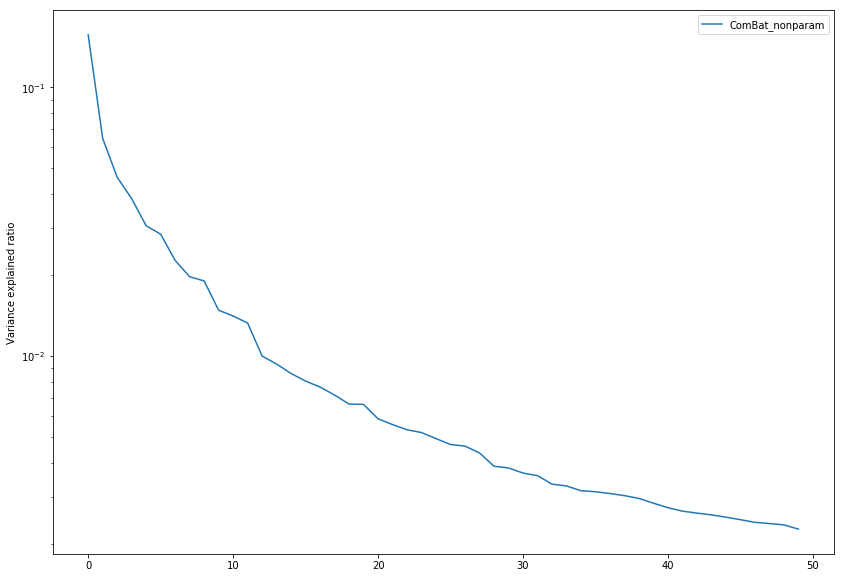

In [42]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

PC's for methylation data:ComBat_nonparam


Text(0.5,0.98,'ComBat_nonparam')

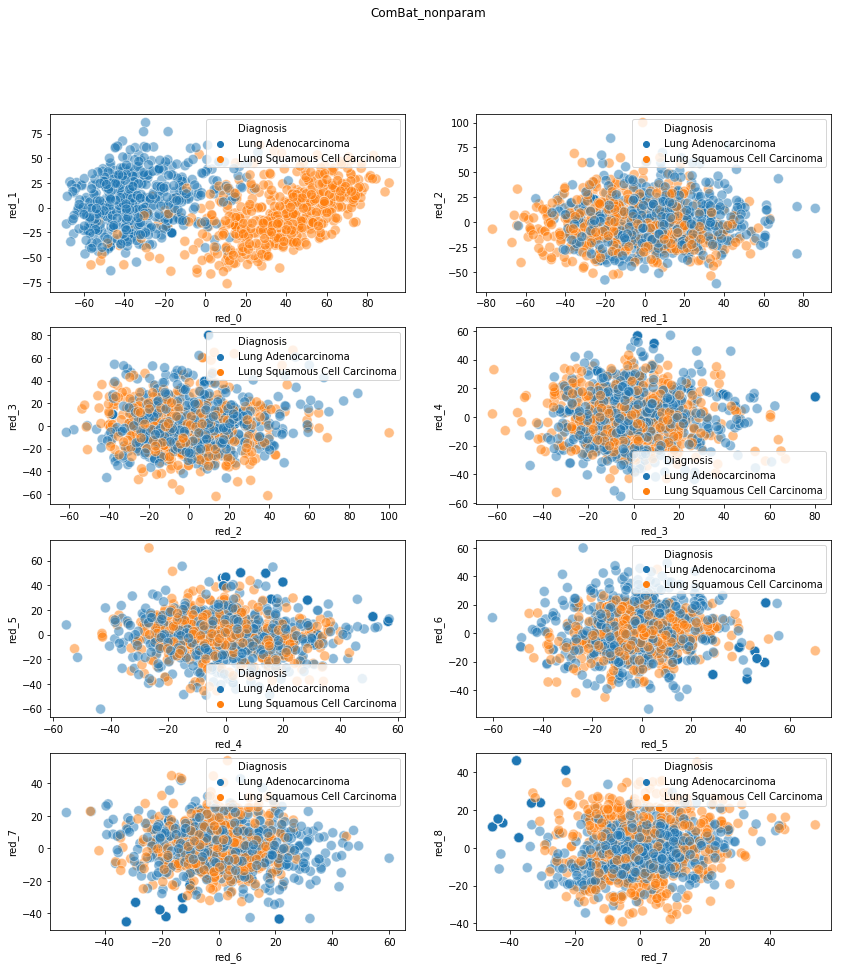

In [43]:
# check PCA, for first components, color by cancer diagnosis.
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(14,15))
key = 'ComBat_nonparam' # ComBat_param,ComBat_nonparam, LS_standard,raw
color_by = 'Diagnosis' # batch_number, Gender, Diagnosis
size_by = None
def_size = 100
style_by = None
print('PC\'s for methylation data:{}'.format(key))
sns.scatterplot(x='red_0', y='red_1', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_1', y='red_2', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[0,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_2', y='red_3', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_3', y='red_4', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[1,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_4', y='red_5', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_5', y='red_6', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[2,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_6', y='red_7', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,0], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
sns.scatterplot(x='red_7', y='red_8', data=data_reduced[key]['ALL']['data'], alpha=0.5, hue=color_by, ax=ax[3,1], 
                size=size_by, sizes=(20,100), style=style_by, s=def_size)
fig.suptitle(key)

In [44]:
_filter= (data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0]>0.015) | \
         (data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0]<-0.015)
pca_0_idx = np.argwhere(_filter)
Genes = data_dict['ComBat_nonparam'].columns[pca_0_idx]

In [45]:
print("Important genes are for the first principal component: \n {}".format(Genes))

Important genes are for the first principal component: 
 Index([['GenX_GCLC.chr6.53497341.53616970.-'],
       ['GenX_ENPP4.chr6.46129993.46146699.+'],
       ['GenX_SEMA3F.chr3.50155045.50189075.+'],
       ['GenX_AOC1.chr7.150824627.150861504.+'],
       ['GenX_KLHL13.chrX.117897813.118117340.-'],
       ['GenX_ICA1.chr7.8113184.8262687.-'],
       ['GenX_TFPI.chr2.187464230.187565760.-'],
       ['GenX_SLC7A2.chr8.17497088.17570573.+'],
       ['GenX_PDK4.chr7.95583499.95596491.-'],
       ['GenX_CRLF1.chr19.18572220.18607741.-'],
       ...
       ['GenX_RP11-350J20.12.chr6.149852462.149853192.+'],
       ['GenX_RP11-66N24.6.chr14.23619201.23620012.+'],
       ['GenX_HNF1B.chr17.37686432.37745247.-'],
       ['GenX_HIST1H2BH.chr6.26251651.26252031.+'],
       ['GenX_AC124789.1.chr17.38450394.38452444.-'],
       ['GenX_MIR205.chr1.209432133.209432242.+'],
       ['GenX_CTC-526N19.1.chr19.33906352.33908391.+'],
       ['GenX_NEFL.chr8.24950955.24957110.-'],
       ['GenX_AC091849.1.

In [46]:
np.quantile(data_reduced['ComBat_nonparam']['ALL']['reducer'].components_[0], 0.005)

-0.016961451857621053

We still see a very strong separation between the two diagnoses after the CBC-correction using ComBat.

What is the seperability of the two classes in the first principal components?

In [47]:
key = 'ComBat_nonparam'  # 'ComBat_param', 'ComBat_nonparam', 'LS_standard', 'raw'
red_cols = ['red_'+str(i) for i in range(0, n_components)]
score_list = []
for _key in data_reduced.keys():
    for idx, _red in enumerate(red_cols):
        scores = ks2(data1=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Adenocarcinoma'").loc[:,_red], 
           data2=data_reduced[_key]['ALL']['data'].query("Diagnosis=='Lung Squamous Cell Carcinoma'").loc[:,_red])
        
        score_list.append({'dim': _red, 
                           'dim_num': idx,
                           'score': scores[0],
                           'pval': scores[1], 
                           'set': _key})
score_df = pd.DataFrame(score_list)

In [153]:
def get_scores(data_dict, Gender='both'):
    # Gender: both, male, female
    score_list_all = {}
    scores = None
    for _key in data_dict.keys():
        cols = [_col for _col in data_dict[_key].columns if 'GenX' in _col]
        
        if Gender=='both':
            vals = data_dict[_key]
        else:
            vals = data_dict[_key].query("Gender=='"+Gender+"'")
        x = vals.loc[:, cols]
        y = vals.Diagnosis.apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1).values

        methods = ['KW', 'FDR', 'KS', 'MWU', 'WASS1', 'WASS2']
        for _method in methods:
            print("Processing {} test for {}..".format(_method, _key))
            df = get_differential_probes(x, y, method=_method)
            if scores is None:
                scores = df
            else:
                scores = scores.copy().merge(df, how='inner', left_index=True, right_index=True)
        scores['Gender'] = Gender
        score_list_all[_key]= scores
    return score_list_all


In [337]:
score_list_all=  get_scores(data_dict, Gender='both')
score_list_male =  get_scores(data_dict, Gender='male')
score_list_female =  get_scores(data_dict, Gender='female')

Processing KW test for ComBat_nonparam..
Processing FDR test for ComBat_nonparam..
Processing KS test for ComBat_nonparam..
Processing MWU test for ComBat_nonparam..
Processing WASS1 test for ComBat_nonparam..
Processing WASS2 test for ComBat_nonparam..
Processing KW test for ComBat_nonparam..
Processing FDR test for ComBat_nonparam..
Processing KS test for ComBat_nonparam..
Processing MWU test for ComBat_nonparam..
Processing WASS1 test for ComBat_nonparam..
Processing WASS2 test for ComBat_nonparam..
Processing KW test for ComBat_nonparam..
Processing FDR test for ComBat_nonparam..
Processing KS test for ComBat_nonparam..
Processing MWU test for ComBat_nonparam..
Processing WASS1 test for ComBat_nonparam..
Processing WASS2 test for ComBat_nonparam..


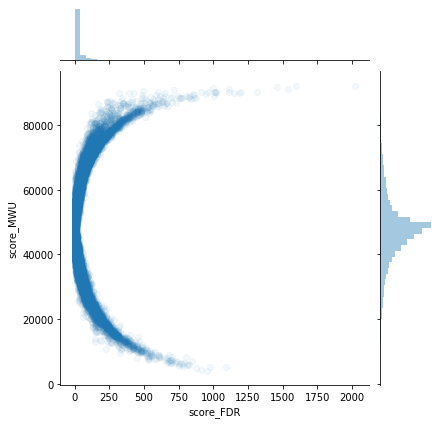

In [150]:
sns.jointplot(data=score_list_all['ComBat_nonparam'], x='score_FDR', y='score_MWU', alpha=0.05)
#sns.jointplot(data=score_list_all_male['ComBat_nonparam'], x='score_FDR', y='score_WASS1', alpha=0.05)
#sns.jointplot(data=score_list_all_female['ComBat_nonparam'], x='score_FDR', y='score_WASS1', alpha=0.05)


In [338]:
score_list_all['ComBat_nonparam'] = score_list_all['ComBat_nonparam'].copy().merge(GeneMap, how='inner', left_index=True, right_index=True)
score_list_male['ComBat_nonparam'] = score_list_male['ComBat_nonparam'].copy().merge(GeneMap, how='inner', left_index=True, right_index=True)
score_list_female['ComBat_nonparam'] = score_list_female['ComBat_nonparam'].copy().merge(GeneMap, how='inner', left_index=True, right_index=True)


score_list_all['ComBat_nonparam'].sort_values(by='score_FDR', ascending=False, inplace=True)
score_list_male['ComBat_nonparam'].sort_values(by='score_FDR', ascending=False, inplace=True)
score_list_female['ComBat_nonparam'].sort_values(by='score_FDR', ascending=False, inplace=True)

In [323]:
data = score_list_all['ComBat_nonparam'].sort_values(by='score_KW', ascending=False)
top_genx = data.index[:6].tolist()
#for _gene in top_genx:
#    data_dict['ComBat_nonparam'].loc[:, _gene].plot.kde(figsize=(18,10), label=_gene)
#plt.legend()
# KRT6A (male)
# KRT6B (female)
# KRT13 (female)
# VSNL1, CLCA2 (female)
# PKP1
# BNC1 (male)
# PVRL1 (male)
# KRT74
# S1PR5
# DSG3
# DSC3
# KRT5
# MIR205HG
# TP63
# CALML3


In [355]:
# fold change from Adenocarcinoma to Squamous cell carcinoma
def fc_make(Gender='both'):
    if Gender=='both':
        vals = data_dict['ComBat_nonparam']
    else:
        vals = data_dict['ComBat_nonparam'].query('Gender=="'+Gender+'"')
    
    fc_split = (vals.query('Diagnosis=="Lung Squamous Cell Carcinoma"').loc[:, GenXlist].median(axis=0)+\
                vals.query('Diagnosis=="Lung Adenocarcinoma"').loc[:, GenXlist].median(axis=0))/2
    fc_abs = vals.query('Diagnosis=="Lung Squamous Cell Carcinoma"').loc[:, GenXlist].mean(axis=0) - \
             vals.query('Diagnosis=="Lung Adenocarcinoma"').loc[:, GenXlist].mean(axis=0)
    fc_rel = fc_abs /vals.query('Diagnosis=="Lung Adenocarcinoma"').loc[:, GenXlist].mean(axis=0) 
    fc_median = vals.query('Diagnosis=="Lung Squamous Cell Carcinoma"').loc[:, GenXlist].median(axis=0) - \
                 vals.query('Diagnosis=="Lung Adenocarcinoma"').loc[:, GenXlist].median(axis=0)

    fc_split_df = pd.DataFrame(data=fc_split, columns=['fc_split'])
    fc_abs_df = pd.DataFrame(data=fc_abs, columns=['fold_change_abs'])
    fc_rel_df = pd.DataFrame(data=fc_rel, columns=['fold_change_rel'])
    fc_median_df = pd.DataFrame(data=fc_median, columns=['fold_change_median'])
    fc = pd.concat([fc_split_df, fc_abs_df, fc_rel_df, fc_median_df], axis=1)
    return fc

In [356]:
fc = {}
fc['both'] = fc_make(Gender='both')
fc['male'] = fc_make(Gender='male')
fc['female'] = fc_make(Gender='female')

In [345]:
score_list_all['ComBat_nonparam'] = score_list_all['ComBat_nonparam'].copy().merge(fc['both'], how='inner', left_index=True, right_index=True)
score_list_male['ComBat_nonparam'] = score_list_male['ComBat_nonparam'].copy().merge(fc['male'], how='inner', left_index=True, right_index=True)
score_list_female['ComBat_nonparam'] = score_list_female['ComBat_nonparam'].copy().merge(fc['female'], how='inner', left_index=True, right_index=True)

In [346]:
# Get LogisticRegressor coeffs
mod_lr = LR(max_iter=300, verbose=1)
mod_lr.fit(x, y)
coefs_LR =pd.DataFrame(data=mod_lr.coef_.reshape([-1,1]), index=x.columns, columns=['LR_coeff_normalised'])
coefs_LR = (coefs_LR - coefs_LR.mean())/coefs_LR.std()
score_list_all['ComBat_nonparam'] = score_list_all['ComBat_nonparam'].copy().merge(coefs_LR, how='inner', left_index=True, right_index=True)
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.0min finished


69

In [347]:
mod_lda = LDA()
mod_lda.fit(x, y)
LDA_scores = pd.DataFrame(data=mod_lda.coef_.reshape([-1,1]), 
                          index=x.columns, 
                          columns=['LDA_score_normalised'])
LDA_scores = (LDA_scores - LDA_scores.mean())/LDA_scores.std()
score_list_all['ComBat_nonparam'] = score_list_all['ComBat_nonparam'].copy().merge(LDA_scores, how='inner', left_index=True, right_index=True)
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


28

In [374]:
score_list_all['ComBat_nonparam'].to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/sep_scores.csv", sep=";")
score_list_male['ComBat_nonparam'].to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/sep_scores_male.csv", sep=";")
score_list_female['ComBat_nonparam'].to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/sep_scores_female.csv", sep=";")

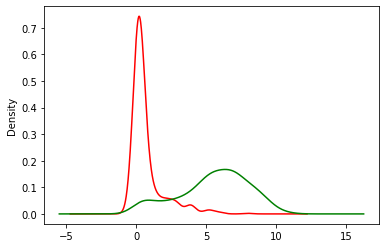

In [402]:
TestGene = 'GenX_KRT6B.chr12.52446651.52452126.-'
x.loc[y==0, TestGene].plot.kde(color='red')
x.loc[y==1, TestGene].plot.kde(color='green')

In [388]:
coefs_LR.sort_values(by='LR_coeff_normalised', ascending=False)

,LR_coeff_normalised
GenX_S100A7.chr1.153457744.153460701.-,23.272873
GenX_KRT6A.chr12.52487174.52493257.-,20.293157
GenX_KRT5.chr12.52514575.52520687.-,20.069741
GenX_AC244250.2.chr22.22664428.22664523.+,14.217734
GenX_CALML3.chr10.5524009.5526771.+,13.151198
GenX_KRT14.chr17.41582279.41586921.-,12.545002
GenX_IGKV6D-21.chr2.90021567.90022185.+,11.903195
GenX_KRT17.chr17.41619437.41624842.-,10.561913
GenX_CEL.chr9.133061978.133087355.+,10.440468
GenX_RPS7P1.chr17.28467822.28468406.+,10.082251


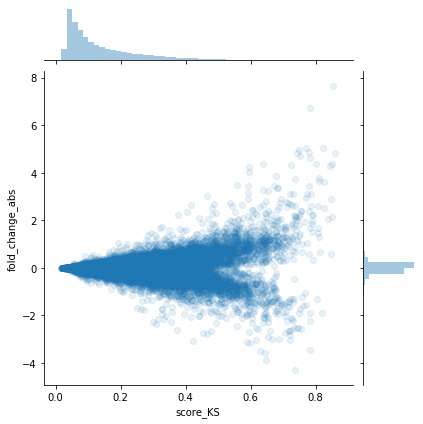

In [207]:
data = score_list_all['ComBat_nonparam']
sns.jointplot(x='score_KS', y='fold_change_abs', data=data, alpha=0.1)

In [123]:
pheno['Diagnosis_num'] = pheno['Diagnosis'].apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
pheno['Gender_num'] = pheno['Gender'].apply(lambda x: 0 if x=='male' else 1)

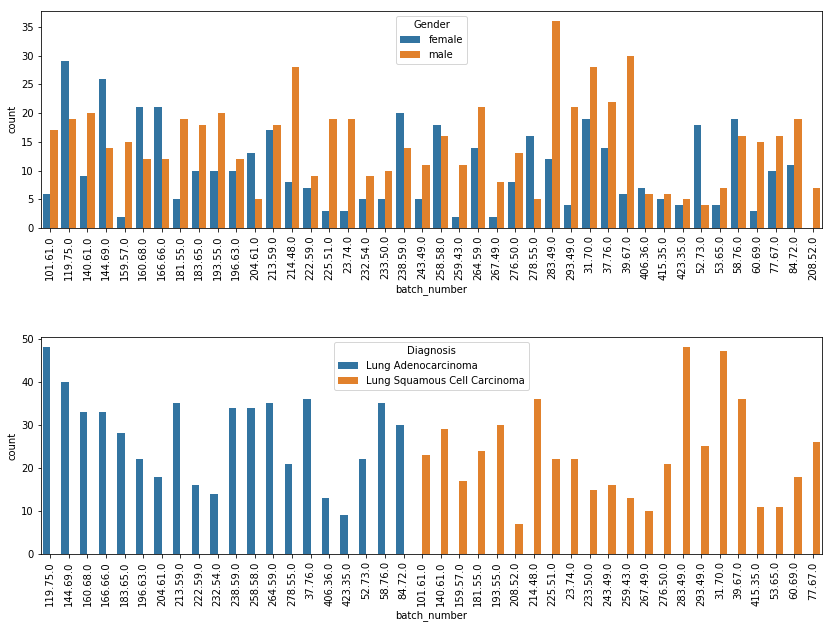

In [213]:
fig, ax = plt.subplots(nrows=2, figsize=(14,10))

pheno_plot = pheno.groupby(['Diagnosis', 'batch_number']).size().reset_index()
pheno_plot.columns=['Diagnosis', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Diagnosis', data=pheno_plot, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)

pheno_plot = pheno.groupby(['Gender', 'batch_number']).size().reset_index()
pheno_plot.columns=['Gender', 'batch_number', 'count']
sns.barplot(x='batch_number', y='count', hue='Gender', data=pheno_plot, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

fig.subplots_adjust(hspace=0.5)

In [208]:
q99=score_list_all['ComBat_nonparam'].score_FDR.quantile(0.99)
top_probes = score_list_all['ComBat_nonparam'].query("pvals_FDR<0.001").query("score_FDR>"+str(q99)).sort_values('score_FDR', ascending=False)

Text(0.5, 1.0, 'Top cancer genes')

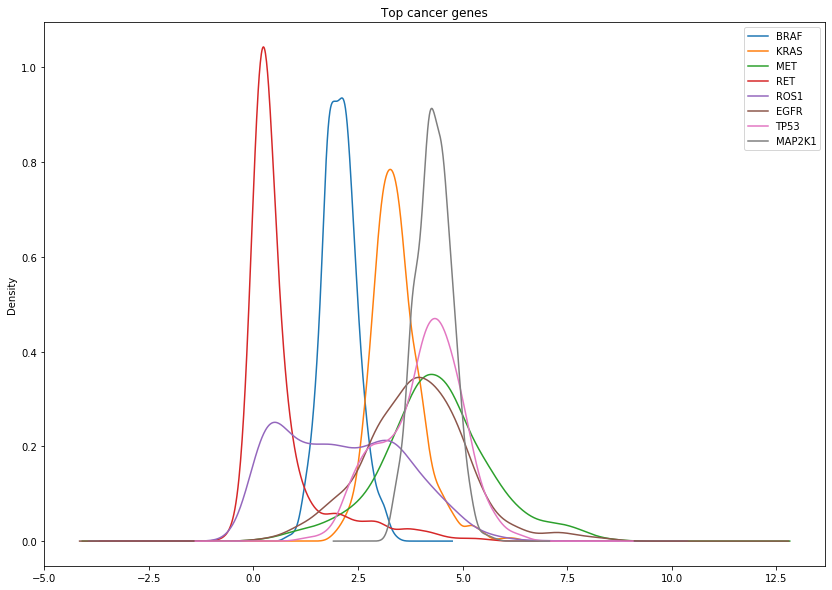

In [55]:
data_dict['ComBat_nonparam']['GenX_BRAF.chr7.140719327.140924764.-'].plot.kde(label='BRAF', figsize=(14,10))

data_dict['ComBat_nonparam']['GenX_KRAS.chr12.25204789.25250936.-'].plot.kde(label='KRAS')

#data_dict['raw']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde() # 
#data_dict['ComBat_nonparam']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde()

data_dict['ComBat_nonparam']['GenX_MET.chr7.116672390.116798386.+'].plot.kde(label='MET')

data_dict['ComBat_nonparam']['GenX_RET.chr10.43077027.43130351.+'].plot.kde(label='RET')

data_dict['ComBat_nonparam']['GenX_ROS1.chr6.117288300.117425855.-'].plot.kde(label='ROS1')

data_dict['ComBat_nonparam']['GenX_EGFR.chr7.55019021.55256620.+'].plot.kde(label='EGFR')

data_dict['ComBat_nonparam']['GenX_TP53.chr17.7661779.7687550.-'].plot.kde(label='TP53')

data_dict['ComBat_nonparam']['GenX_MAP2K1.chr15.66386817.66492312.+'].plot.kde(label='MAP2K1')

plt.legend()
plt.title("Top cancer genes")

Text(0.5, 1.0, 'Top differential cancer genes')

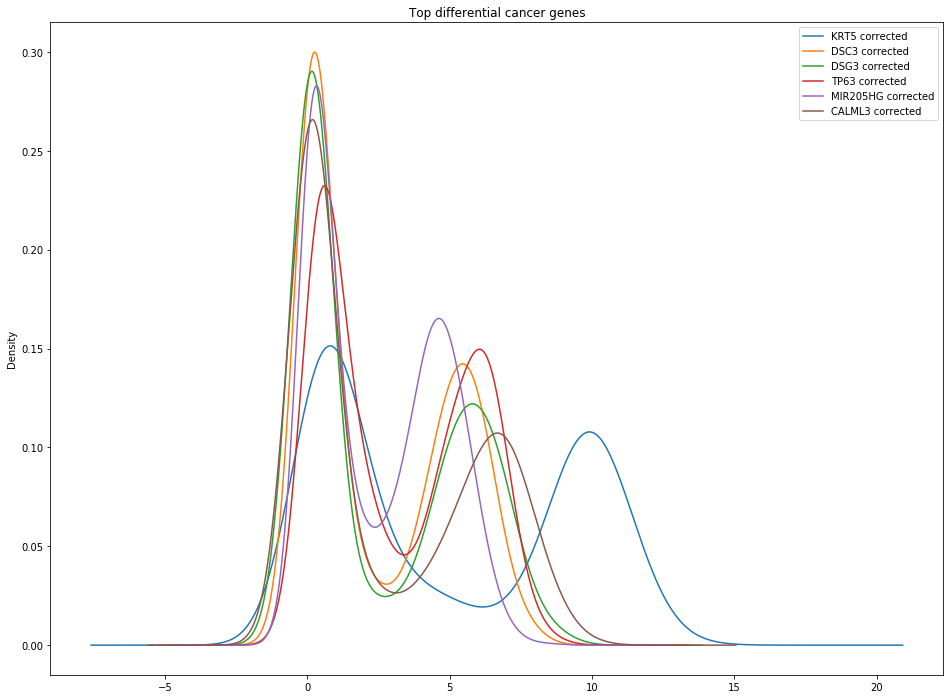

In [56]:
data_dict['ComBat_nonparam']['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(label='KRT5 corrected',figsize=(16,12))

data_dict['ComBat_nonparam']['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde(label='DSC3 corrected')

#data_dict['raw']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde() # 
#data_dict['ComBat_nonparam']['GenX_KLKB1.chr4.186208979.186258471.+'].plot.kde()

data_dict['ComBat_nonparam']['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde(label='DSG3 corrected')

data_dict['ComBat_nonparam']['GenX_TP63.chr3.189631416.189897279.+'].plot.kde(label='TP63 corrected')

data_dict['ComBat_nonparam']['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde(label='MIR205HG corrected')

data_dict['ComBat_nonparam']['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde(label='CALML3 corrected')

plt.legend()
plt.title("Top differential cancer genes")

In [505]:
from matplotlib.lines import Line2D
Line2D.markers

{'.': 'point',
 ',': 'pixel',
 'o': 'circle',
 'v': 'triangle_down',
 '^': 'triangle_up',
 '<': 'triangle_left',
 '>': 'triangle_right',
 '1': 'tri_down',
 '2': 'tri_up',
 '3': 'tri_left',
 '4': 'tri_right',
 '8': 'octagon',
 's': 'square',
 'p': 'pentagon',
 '*': 'star',
 'h': 'hexagon1',
 'H': 'hexagon2',
 '+': 'plus',
 'x': 'x',
 'D': 'diamond',
 'd': 'thin_diamond',
 '|': 'vline',
 '_': 'hline',
 'P': 'plus_filled',
 'X': 'x_filled',
 0: 'tickleft',
 1: 'tickright',
 2: 'tickup',
 3: 'tickdown',
 4: 'caretleft',
 5: 'caretright',
 6: 'caretup',
 7: 'caretdown',
 8: 'caretleftbase',
 9: 'caretrightbase',
 10: 'caretupbase',
 11: 'caretdownbase',
 'None': 'nothing',
 None: 'nothing',
 ' ': 'nothing',
 '': 'nothing'}

Text(0.5,1,'Top differential cancer genes')

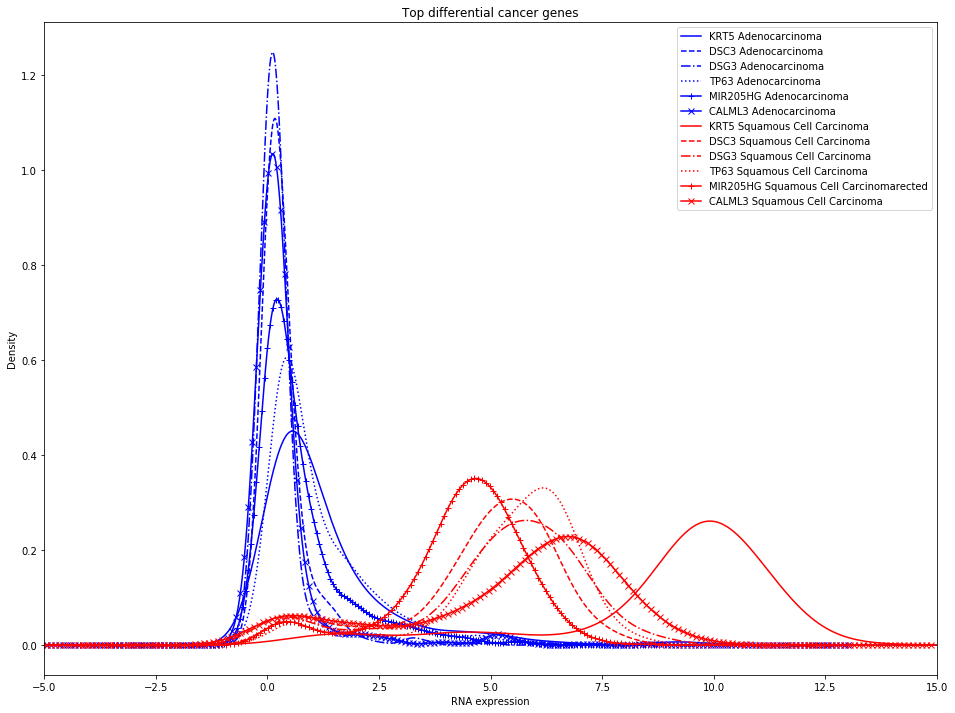

In [817]:
data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(figsize=(16,12), color='blue', 
                                                         label='KRT5 Adenocarcinoma',
                                                         style="-")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde( color='blue',
                                                         label='DSC3 Adenocarcinoma',
                                                         style="--")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde( color='blue',
                                                         label='DSG3 Adenocarcinoma',
                                                         style="-.")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_TP63.chr3.189631416.189897279.+'].plot.kde( color='blue',
                                                          label='TP63 Adenocarcinoma',
                                                         style=":")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde( color='blue',
                                                              label='MIR205HG Adenocarcinoma',
                                                              marker="+",
                                                              markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Adenocarcinoma"')\
        ['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde( color='blue',
                                                         label='CALML3 Adenocarcinoma',
                                                         marker="x",
                                                         markevery=5)


data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_KRT5.chr12.52514575.52520687.-'].plot.kde(figsize=(16,12), color='red', 
                                                         label='KRT5 Squamous Cell Carcinoma',
                                                         style="-")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_DSC3.chr18.30990008.31042815.-'].plot.kde( color='red',
                                                         label='DSC3 Squamous Cell Carcinoma',
                                                         style="--")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_DSG3.chr18.31447795.31478702.+'].plot.kde( color='red',
                                                         label='DSG3 Squamous Cell Carcinoma',
                                                         style="-.")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_TP63.chr3.189631416.189897279.+'].plot.kde( color='red',
                                                          label='TP63 Squamous Cell Carcinoma',
                                                         style=":")

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_MIR205HG.chr1.209428820.209432838.+'].plot.kde( color='red',
                                                              label='MIR205HG Squamous Cell Carcinomarected',
                                                             marker='+',
                                                             markevery=5)

data_dict['ComBat_nonparam'].query('Diagnosis=="Lung Squamous Cell Carcinoma"')\
        ['GenX_CALML3.chr10.5524009.5526771.+'].plot.kde( color='red',
                                                         label='CALML3 Squamous Cell Carcinoma',
                                                         marker='x',
                                                         markevery=5)

plt.xlim(-5,15)
plt.xlabel('RNA expression')
plt.legend()
plt.title("Top differential cancer genes")

From the distributions above you can clearly see that the two lung cancer diagnoses can be seperated by these six genes.

In [208]:
data_dict['ComBat_nonparam']['Diagnosis'].value_counts()

Lung Adenocarcinoma             549
Lung Squamous Cell Carcinoma    504
Name: Diagnosis, dtype: int64

In [226]:
sep_list = ['GenX_KRT5.chr12.52514575.52520687.-', 
         'GenX_DSC3.chr18.30990008.31042815.-',
         'GenX_DSG3.chr18.31447795.31478702.+',
         'GenX_TP63.chr3.189631416.189897279.+',
         'GenX_MIR205HG.chr1.209428820.209432838.+',
         'GenX_CALML3.chr10.5524009.5526771.+']

vals = data_dict['ComBat_nonparam'].query('Gender!="*"')

lscc_appr = vals.loc[(vals[sep_list[0]]>2.5) &
                                             (vals[sep_list[1]]>2.5) &
                                             (vals[sep_list[2]]>2.5) &
                                             (vals[sep_list[3]]>2.5) &
                                             (vals[sep_list[4]]>2.5) &
                                             (vals[sep_list[5]]>2.5),'Diagnosis'].value_counts()
la_appr = vals.loc[(vals[sep_list[0]]<2.5) &
                                 (vals[sep_list[1]]<2.5) &
                                 (vals[sep_list[2]]<2.5) &
                                 (vals[sep_list[3]]<2.5) &
                                 (vals[sep_list[4]]<2.5) &
                                 (vals[sep_list[5]]<2.5),'Diagnosis'].value_counts()



In [237]:
from scipy.optimize import differential_evolution as de
def _sep_opt(v, opt=True):
    a = v[0]
    b = v[1]
    c = v[2]
    d = v[3]
    e = v[4]
    f = v[5]
    lscc_appr = data_dict['ComBat_nonparam'].loc[(data_dict['ComBat_nonparam'][sep_list[0]]>a) &
                                     (data_dict['ComBat_nonparam'][sep_list[1]]>b) &
                                     (data_dict['ComBat_nonparam'][sep_list[2]]>c) &
                                     (data_dict['ComBat_nonparam'][sep_list[3]]>d) &
                                     (data_dict['ComBat_nonparam'][sep_list[4]]>e) &
                                     (data_dict['ComBat_nonparam'][sep_list[5]]>f),'Diagnosis'].value_counts()
    la_appr = data_dict['ComBat_nonparam'].loc[(data_dict['ComBat_nonparam'][sep_list[0]]<a) &
                                     (data_dict['ComBat_nonparam'][sep_list[1]]<b) &
                                     (data_dict['ComBat_nonparam'][sep_list[2]]<c) &
                                     (data_dict['ComBat_nonparam'][sep_list[3]]<d) &
                                     (data_dict['ComBat_nonparam'][sep_list[4]]<e) &
                                     (data_dict['ComBat_nonparam'][sep_list[5]]<f),'Diagnosis'].value_counts()    
    prec_lscc = lscc_appr[0]/lscc_appr.sum()
    prec_la = la_appr[0]/la_appr.sum()
    recall_lscc = lscc_appr[0]/504
    recall_la = la_appr[0]/549
    f1_lscc = 2/(1/recall_lscc + 1/prec_lscc)
    f1_la = 2/(1/recall_la+ 1/prec_la)
    mean_f1 = (f1_lscc+f1_la)/2
    
    if opt==False:
        return {'prec_lscc': prec_lscc, 
                'prec_la': prec_la, 
                'recall_lscc': recall_lscc,
                'recall_la': recall_la,
                'f1_lscc': f1_lscc, 
                'f1_la': f1_la}
    else:
        return -mean_f1

In [238]:
rtup = (2,3)
res = de(_sep_opt, bounds=[rtup, rtup, rtup, rtup, rtup, rtup], maxiter=100)
print(-_sep_opt(res.x))

0.8615377677564825


In [239]:
_sep_opt(res.x, opt=False)

{'prec_lscc': 0.9947780678851175,
 'prec_la': 0.9578713968957872,
 'recall_lscc': 0.7559523809523809,
 'recall_la': 0.7868852459016393,
 'f1_lscc': 0.859075535512965,
 'f1_la': 0.864}

For the following classification test we only use the genes ```KRT5, DSC3, DSG3, TP63, MIR205HG, CALML3```.

If we simplistically take an RNA-expression value of $2.5$ as the seperator between LA/LSCC we get the following estimates: 


|================| LSCC actual | LA actual |
|----------------|-------------|-----------|
| LSCC predicted | **384**     | 19        |
| LA predicted   | 4           |  **404**  |



With the following scores:

|========== | recall   	    |  precision  | F1 score  |
|---	    |---	        |---          |---  |
|  LSCC  	|  $76\%$  	  	|   $99\%$    | $0.86$|
|  LA    	|  $74\%$ 	    |   $95\%$    | $0.83$|

With a total actual LSCC, LA of $504$ and $549$ respectively 

The high number of dimensions with respect to the number of samples opens up the question whether or not the seperations are fortuitous (e.g. random) or actually meaningful.
We have about $60.000$ dimensions and about $900$ samples, i.e. the dimension/sample ratio is about $60:1$. The question is: how likely is it that
along $1$ dimension the $900$ samples are seperated evenly and correctly in two classes?

Given a random distribution of the two classes over $900$ samples. The probability that for a particular
dimension there is a correct distinction between two classes over $M$ samples is roughly $\propto \rho^M$ where $M$ is the number of samples and $\rho$ is 
the prior probability of class A (where the proba for class B is $1-\rho$). This amounts to a negligible probability of a correct random assignment
for one dimension, let alone for $6$ dimensions. 

## Intra-cohort and inter-cohort median


median shift distribution: $\Delta median$

In [19]:
data_dict['raw'].Diagnosis.unique()

array(['Lung Adenocarcinoma', 'Lung Squamous Cell Carcinoma', nan],
      dtype=object)

In [20]:
genx_cols = [_col for _col in data_dict['raw'].columns if 'GenX' in _col]
x_dict = {}
x_dict['LA'] = data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Adenocarcinoma', genx_cols].values
x_dict['LSCC'] = data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Squamous Cell Carcinoma', genx_cols].values

batches_dict = {}
batches_dict['LA'] = np.array(data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Adenocarcinoma']\
                              .batch_number.unique().tolist())
batches_dict['LA'] = batches_dict['LA'][batches_dict['LA']!='nan']

batches_dict['LSCC'] = np.array(data_dict['raw'].loc[data_dict['raw'].Diagnosis=='Lung Squamous Cell Carcinoma']\
                                .batch_number.unique().tolist())
batches_dict['LSCC'] = batches_dict['LSCC'][batches_dict['LSCC']!='nan']

In [21]:
index_map={}
index_map['raw'] = data_dict['raw'].reset_index()[['index']]
data_dict['raw'] = data_dict['raw'].reset_index().drop('index', axis=1)

In [22]:
names = {'LA': 'Lung Adenocarcinoma',
         'LSCC': 'Lung Squamous Cell Carcinoma'}

In [23]:
batch_dict = {}
sample_ids = data_dict['raw'].index.values

for _ds in batches_dict.keys():
    batches = batches_dict[_ds]
    batch_dict[_ds] = {} 
    ds = data_dict['raw'].query('Diagnosis=="'+names[_ds]+'"').reset_index()
    for _batch in batches:
        batch_dict[_ds][_batch] = ds.query('batch_number=="'+str(_batch)+'"').index.values

batch_dict_all = {}
for _ds in batches_dict.keys():
    batches = batches_dict[_ds]
    batch_dict_all[_ds] = {} 
    ds = data_dict['raw'].query('Diagnosis=="'+names[_ds]+'"')
    for _batch in batches:
        batch_dict_all[_ds][_batch] = ds.query('batch_number=="'+str(_batch)+'"').index.values

In [684]:
median_shifts = {}
median_shifts['raw'] = {'LA': median_shift(x_dict['LA'].T, batch_dict['LA'])}
median_shifts['raw']['LSCC'] =  median_shift(x_dict['LSCC'].T, batch_dict['LSCC'])

mean_shifts = {}
mean_shifts['raw'] = {'LA': mean_shift(x_dict['LA'].T, batch_dict['LA'])}
mean_shifts['raw']['LSCC'] = mean_shift(x_dict['LSCC'].T, batch_dict['LSCC'])


20it [00:19,  1.01it/s]
22it [00:18,  1.16it/s]
20it [00:08,  2.38it/s]
22it [00:08,  2.71it/s]


Text(0.5,0.98,'Original uncorrected data, RNA expression')

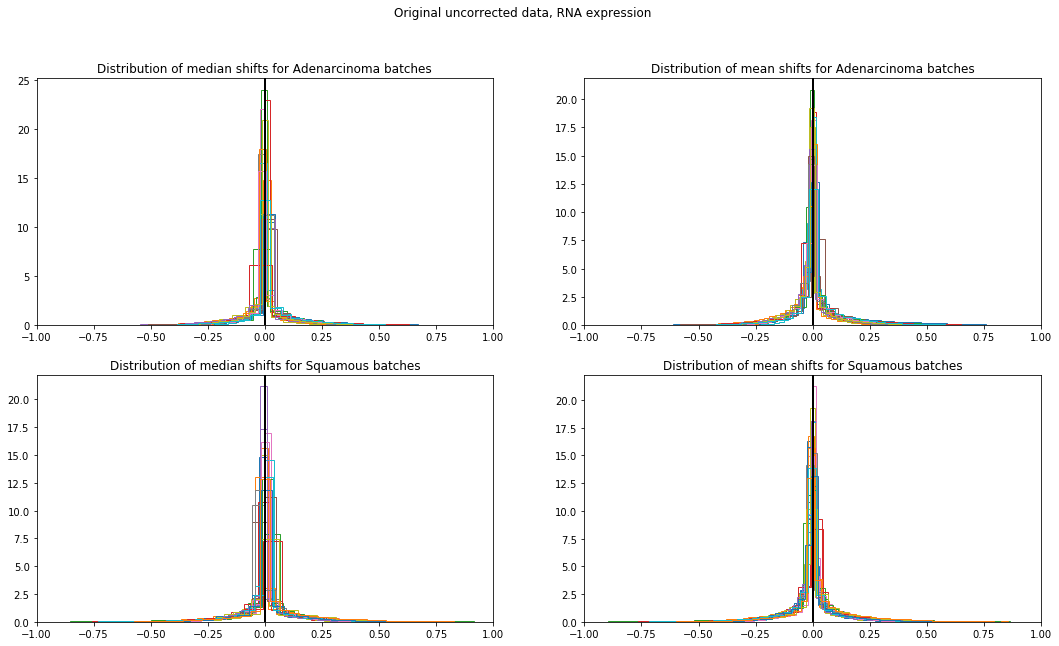

In [738]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(18,10))

for i in range(0,median_shifts['raw']['LA'].shape[1]):
    ax[0,0].hist(median_shifts['raw']['LA'][:,i], bins=120, histtype='step', density=True);
    ax[0,0].set_xlim(-1,1)
    ax[0,0].axvline(0,color='black')
    ax[0,0].set_title('Distribution of median shifts for Adenarcinoma batches')
    
for i in range(0,median_shifts['raw']['LA'].shape[1]):
    ax[0,1].hist(mean_shifts['raw']['LA'][:,i], bins=120, histtype='step', density=True);    
    ax[0,1].set_xlim(-1,1)
    ax[0,1].axvline(0,color='black')
    ax[0,1].set_title('Distribution of mean shifts for Adenarcinoma batches')
    
for i in range(0,median_shifts['raw']['LSCC'].shape[1]):
    ax[1,0].hist(median_shifts['raw']['LSCC'][:,i], bins=120, histtype='step', density=True);
    ax[1,0].set_xlim(-1,1)
    ax[1,0].axvline(0,color='black')
    ax[1,0].set_title('Distribution of median shifts for Squamous batches')
    
for i in range(0,median_shifts['raw']['LSCC'].shape[1]):
    ax[1,1].hist(mean_shifts['raw']['LSCC'][:,i], bins=120, histtype='step', density=True);    
    ax[1,1].set_xlim(-1,1)
    ax[1,1].axvline(0,color='black')
    ax[1,1].set_title('Distribution of mean shifts for Squamous batches')
    
plt.suptitle('Original uncorrected data, RNA expression')


The probe medians and means do not appear to be shifted significantly between the batches.

# Probewise similarity

Paired similarity measures are
* Kullback-Leibler divergence or Jensen-Shannon divergence
* cosine distance (or any other vectorial similarity such as the Euclidean distance)

Unpaired similarity measures are
* Wasserstein distances (1st is Earth Mover Distance, 2nd is energy distance)
* Mann-Whitney U
* Kolmogorov-Smirnov
* Kruskal Wallis
* Anderson-Darling (tests for normality)
* Cramér-Von Mises (tests for normality)
* Cramér distance

We can determine and compare the intra-cohort similarities and the inter-cohort similarities.

In [951]:
#import importlib
#print(pd.__version__)
#importlib.reload(pd.core)

In [34]:
import matplotlib.pyplot as plt

euclid = lambda x1, x2: sc.spatial.distance.euclidean(x1, x2)
cosine = lambda x1, x2: sc.spatial.distance.cosine(x1, x2)
correl = lambda x1, x2: sc.spatial.distance.correlation(x1, x2)
pearsonrl = lambda x1, x2: sc.stats.pearsonr(x1, x2)

IndTuple = tuple([_batch for _batch in batch_dict_all['LA'].values()])
combo_list = np.hstack(IndTuple)
corr_sub_LA = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all_LA = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)

IndTuple = tuple([_batch for _batch in batch_dict_all['LSCC'].values()])
combo_list = np.hstack(IndTuple)
corr_sub_LSCC = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all_LSCC = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)


In [109]:
IndTuple_LSCC = tuple([_batch for _batch in batch_dict_all['LSCC'].values()])
IndTuple_LA = tuple([_batch for _batch in batch_dict_all['LA'].values()])

combo_list_LSCC = np.hstack(IndTuple_LSCC)
combo_list_LA = np.hstack(IndTuple_LA)
combo_list = np.hstack((combo_list_LSCC,combo_list_LA))

corr_sub = (data_dict['raw'].iloc[combo_list, pca_0_idx.T[0]].T).corr(method=euclid)
corr_all = (data_dict['raw'].iloc[combo_list, list(range(0, len(GenX_columns)))].T).corr(method=euclid)

Text(0.5,0.98,'Patient correlations, left block is LSCC, right block is LA')

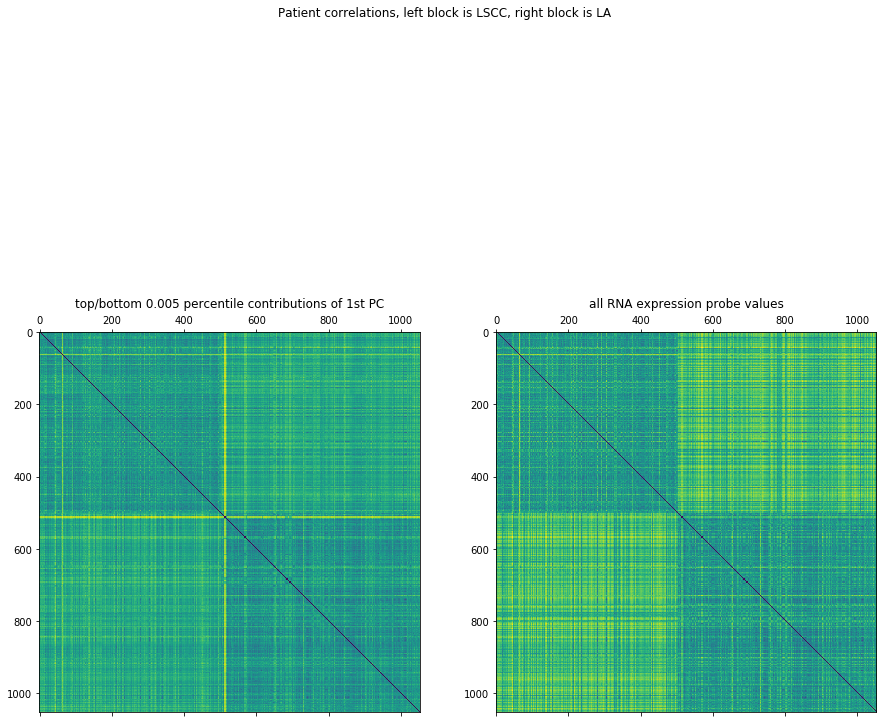

In [118]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
inflate = 1.
ax[0].matshow(corr_all**inflate)
ax[1].matshow(corr_sub**inflate)
ax[0].set_title('top/bottom 0.005 percentile contributions of 1st PC')
ax[1].set_title('all RNA expression probe values')
fig.suptitle('Patient correlations, left block is LSCC, right block is LA')

#ax[1,0].matshow(corr_sub_LSCC**inflate)
#ax[1,1].matshow(corr_all_LSCC**inflate)
#ax[1,0].set_title('Squamous, top/bottom 0.005 percentile contributions of 1st PC')
#ax[1,1].set_title('Squamous, all RNA expression probe values')

In [128]:
# Perhaps it is possible to cluster the sqeamous and adenocarcinoma samples 
# hierarchical clustering (hdbscan)
import hdbscan
hdb_cluster = hdbscan.HDBSCAN(min_cluster_size=50, alpha=.9, leaf_size=5, min_samples=None, p=None,
                              metric='euclidean', 
                              gen_min_span_tree=True,
                              approx_min_span_tree=True)
hdb_cluster.fit(corr_all.values)


/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:216: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=0.9,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=5,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=50, min_samples=None, p=None,
    prediction_data=False)

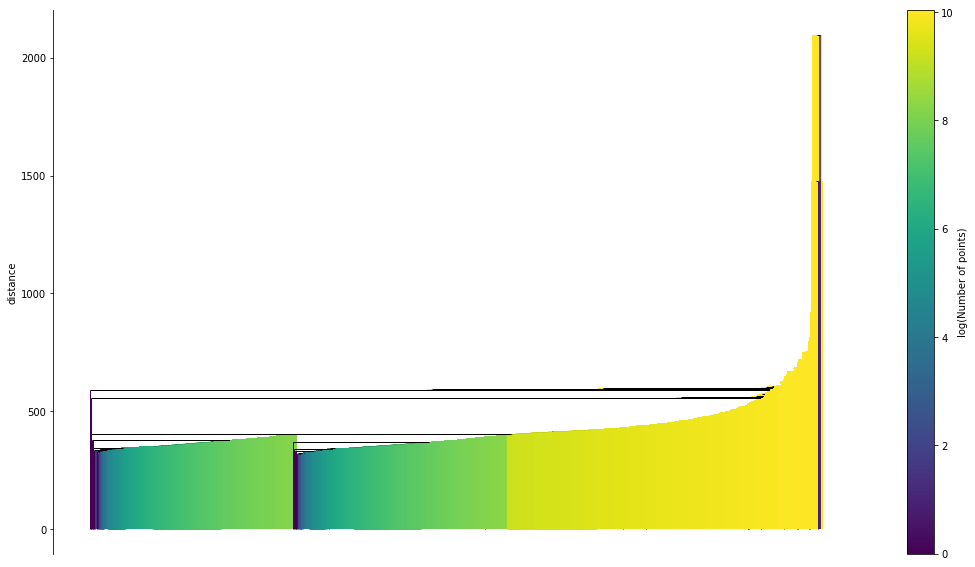

In [129]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

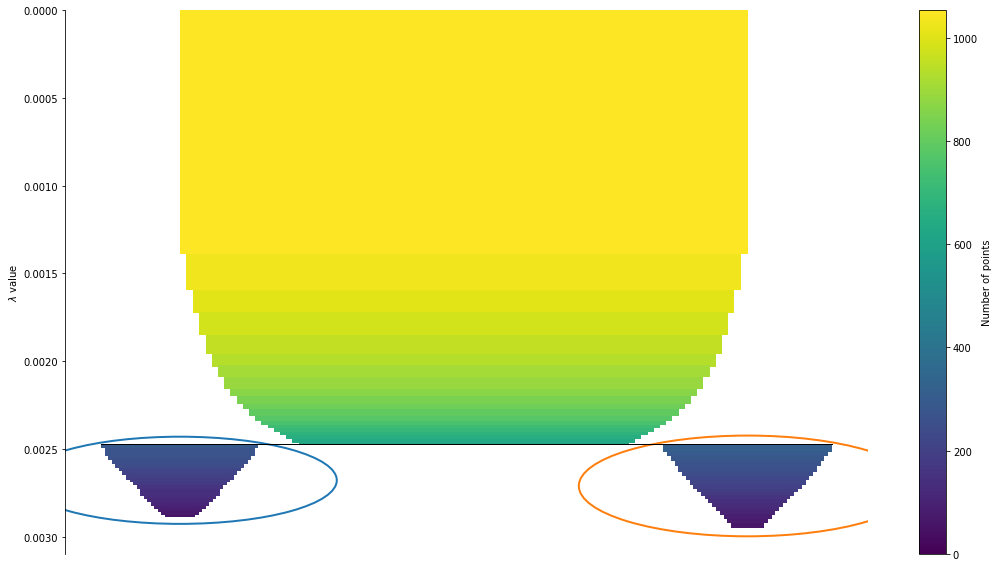

In [130]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [157]:
hdb_cluster_raw = hdbscan.HDBSCAN(min_cluster_size=10, alpha=.9, leaf_size=5, min_samples=None, p=None,
                              metric='euclidean', 
                              core_dist_n_jobs = 8,
                              gen_min_span_tree=True,
                              approx_min_span_tree=True)
hdb_cluster_raw.fit(data_dict['raw'].loc[:, GenX_columns].values)

/usr/local/lib/python3.6/dist-packages/hdbscan/hdbscan_.py:216: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=0.9,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=8, gen_min_span_tree=True, leaf_size=5,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=10, min_samples=None, p=None,
    prediction_data=False)

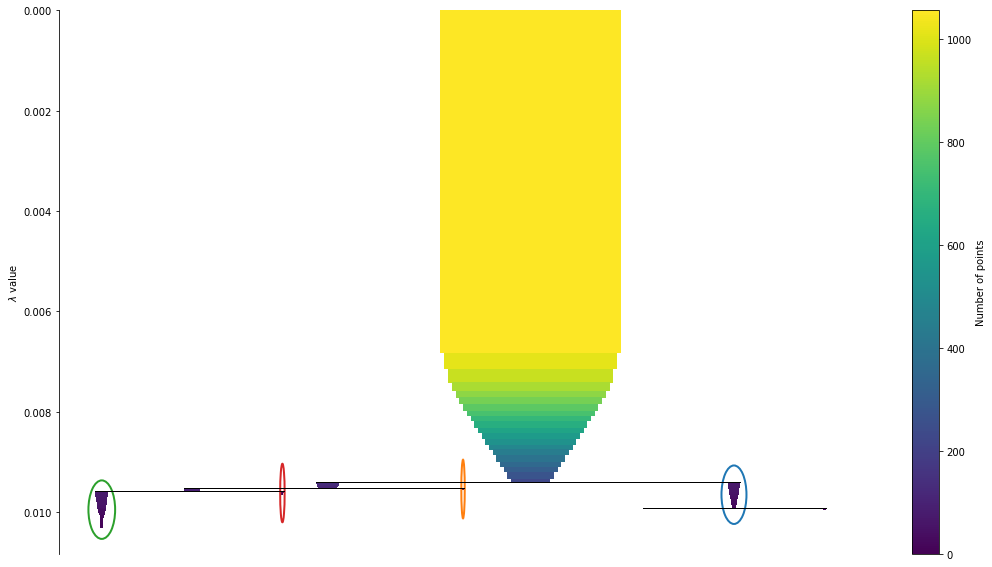

In [158]:
fig, ax = plt.subplots(figsize=(18,10))
hdb_cluster_raw.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [159]:
cluster_assignment_pre = pd.DataFrame(data=np.vstack((hdb_cluster.probabilities_, hdb_cluster.labels_)).T,
                                  columns=['proba', 'label'],
                                  index=corr_all.index)
cluster_assignment_raw = pd.DataFrame(data=np.vstack((hdb_cluster_raw.probabilities_, hdb_cluster_raw.labels_)).T,
                                  columns=['proba', 'label'],
                                  index=data_dict['raw'].index)

In [162]:
print(cluster_assignment_raw.label.value_counts())
print("+"*30)
print(cluster_assignment_pre.label.value_counts())

-1.0    881
 2.0     78
 0.0     73
 3.0     13
 1.0     10
Name: label, dtype: int64
++++++++++++++++++++++++++++++
-1.0    449
 1.0    313
 0.0    291
Name: label, dtype: int64


In [192]:
no_cluster_index = cluster_assignment_pre[cluster_assignment_pre.label==-1.0].index.values
cluster_0_index = cluster_assignment_pre[cluster_assignment_pre.label==1.0].index.values
cluster_1_index = cluster_assignment_pre[cluster_assignment_pre.label==0.0].index.values

In [199]:
print(data_dict['raw'].iloc[cluster_0_index,:]['Diagnosis'].value_counts())
print("+"*30)
print(data_dict['raw'].iloc[cluster_1_index,:]['Diagnosis'].value_counts())


Lung Adenocarcinoma             301
Lung Squamous Cell Carcinoma     12
Name: Diagnosis, dtype: int64
++++++++++++++++++++++++++++++
Lung Squamous Cell Carcinoma    290
Lung Adenocarcinoma               1
Name: Diagnosis, dtype: int64


We see that we naturally arrive at two clusters, starting from either the raw data or the similarity data.
These two clusters are the LSCC and LA sample groups. For the similarity data about $50\%$ of the cluster assignment are determined, for the raw data only $15\%$. 

## Classifier

By training a non-linear classifier we can identify combinations of factors that seperate the target values. 

We use the Explainable Boosting Machine developed by Microsoft. This is a Generalised Additive Model with pairwise interactions, allowing good explainability, that is augmented with boosting and bagging techniques to improve the accuracy. See [Caruana et al.](http://people.dbmi.columbia.edu/noemie/papers/15kdd.pdf)

The expectation $\mathcal{E}$ for a certain target value $y$ given a input vector $\mathbf{x}$ is given by a function $g$:
$$
g\left(\mathcal{E}[y]\right)= \beta_0 \underset{j}{\sum}f_j(x_j + \underset{i}{\sum}\underset{j}{\sum} f_{i,j} (x_i, x_j),\, i \neq j
$$

The inclusion of pairwise interaction is also interesting for studying the combination of methylation and RNA expression.


In [4]:
from interpret.glassbox import ExplainableBoostingClassifier as EBC
from interpret.glassbox import ClassificationTree as CT
from interpret.glassbox import DecisionListClassifier as DT
from interpret import show
from interpret.data import ClassHistogram
from interpret.perf import ROC

In [ ]:
# We use the PC's of the genetic expression values, and we append the phenotypical features.

In [ ]:
# We have the make sure that the phenotypical features have a suitable type.

In [ ]:
# We do not bother with the train/test splitting because we are primarily interested in feature importances
EBclassifier = EBC(n_jobs=8, n_estimators=50)
EBclassifier.fit(X, y)

In [ ]:
ebm_global = EBclassifier.explain_global(name="EBM")
show(ebm_global)

In [ ]:
ebm_local = EBclassifier.explain_local(X[:5], y[:5], name="EBM")
show(ebm_local)

In [ ]:
# in case we are interested in prediction accuracy..
#ebm_perf = ROC(EBclassifier.predict_proba).explain_perf(X_test, y_test, name='EBM')
#show(ebm_perf)

In [ ]:
## RadViz and  parallel coordinates
from yellowbrick.features import RadViz
feature_names = ['most important genes']
classes = ['LA', 'LSCC']

radvizer = RadViz(classes=classes, 
                  features=feature_names, 
                  size=(800, 300))

radvizer.fit(X_small, y)
radvizer.transform(X_small)
radvizer.poof()

In [ ]:
from yellowbrick.features import ParallelCoordinates as PARCOR
parvizer = PARCOR(classes=classes, 
                  features=feature_names,
                  normalize='standard',
                  sample=0.1, 
                  size=(800,300))

parvizer.fit(X_small, y)
parvizer.transform(X_small)
parvizer.poof()

## Custom classifier, 1-pass information extractor for bi-nominal problem

Given the separation scores from the unpaired tests we can identify the dimensions along which we can effectively separate the

* (1) get split of class distro's by median's
* (2) extract class entropy from split with minimum-threshold accuracy
* (3) optimize using differential evolution

The result is a very small model that is easy to interpret with high accuracy, but likely a low recall.

In [434]:
# fold_change_median, fc_split
splt = score_list_all['ComBat_nonparam'][['fold_change_median', 'fc_split']].reset_index()
tmp=pd.DataFrame(data=x[y==0].std(axis=0), columns=['std_LA'])
splt = splt.copy().merge(tmp, how='inner', left_on='index', right_index=True)
tmp=pd.DataFrame(data=x[y==1].std(axis=0), columns=['std_LSCC'])
splt = splt.copy().merge(tmp, how='inner', left_on='index', right_index=True)
splt['adapted_fold_change'] = 2*splt.fold_change_median/(splt.std_LA+splt.std_LSCC) # correct for large std's
# you can introduce the effect of Kurtosis and Skewness as well.

In [511]:
# sign of fold change directly translates in > of < condition for the split
# Entropy = - (sum(p(A)*log2(p(A)) + p(B)*log2(p(B))) 
# Accuracy = MAX(MAX(p(A), p(B))_L, MAX(p(A), p(B))_R)

def super_simple_model(x, y, splt, min_lscc=0.75, min_la=0.75, max_consecutive_fail=50, adapted_sort=False):
    # not optimized, super slow
    rnk_var = 'adapted_fold_change' if adapted_sort else 'fold_change_median'
    splt = splt.copy().reindex(splt[rnk_var].abs().sort_values(ascending=False).index)
    
    x_train = x.copy()
    x_train['y'] = y
    
    fail = 0 
    rules = []
    for row in splt.iterrows():
        split_gen = row[1]['index']
        fc_split =row[1]['fc_split']
        v1 = x_train.loc[x[split_gen]<fc_split].y.mean()
        v2 = x_train.loc[x[split_gen]>fc_split].y.mean()

        acc_lscc = np.max([v1, v2])
        acc_la = np.max([1-v1,1-v2])
        if (acc_lscc>min_lscc) and (acc_la>min_la):
            rules.append({'acc_lscc': acc_lscc, 'acc_la': acc_la, 'split' : fc_split, 'dim': split_gen, 'sign': v2>v1})
            fail=0
        else:
            fail+=1
        if (fail>max_consecutive_fail) and (max_consecutive_fail!=-1) and (max_consecutive_fail is not None):
            return pd.DataFrame(rules)
    return pd.DataFrame(rules)

In [512]:
split_genes = super_simple_model(x, y, splt, min_lscc=0.8, min_la=0.8, max_consecutive_fail=50, adapted_sort=True);
split_genes.set_index('dim', inplace=True)
split_genes = split_genes.copy().merge(score_list_all['ComBat_nonparam'], how='left', left_index=True, right_index=True)
split_genes.rename(index=str, columns={'sign': 'lscc_on_the_rightside_of_split'}, inplace=True)
split_genes.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/best_splits.csv", sep=";")

In [516]:
split_genes.columns

Index(['acc_la', 'acc_lscc', 'lscc_on_the_rightside_of_split', 'split',
       'pvals_KW', 'score_KW', 'pvals_FDR', 'score_FDR', 'pvals_KS',
       'score_KS', 'pvals_MWU', 'score_MWU', 'score_WASS1', 'score_WASS2',
       'Gender', 'Chr', 'Gene', 'Start', 'Stop', 'Strand', 'fc_split',
       'fold_change_abs', 'fold_change_rel', 'fold_change_median',
       'LR_coeff_normalised', 'LDA_score_normalised'],
      dtype='object')

# Key results 

* top separating RNA expression genes, their fold changes and their accuracy/f1 in separating the two cancer types
* no significant batch effect
* list of fold changes -> export to file
